In [184]:
import numpy as np
import matplotlib.pyplot as plt
import cmocean.cm as cmo
from numba import njit
import xarray as xr
from pathlib import Path
import shutil
from matplotlib import rc
import dask

In [96]:
pwd

'/Users/goldsworth/Documents/dwbc-proj/src/toy_model'

In [101]:
base_path = Path('/Users/goldsworth/Documents/dwbc-proj')
processed_path = base_path /'data/processed'

## One dimensional model

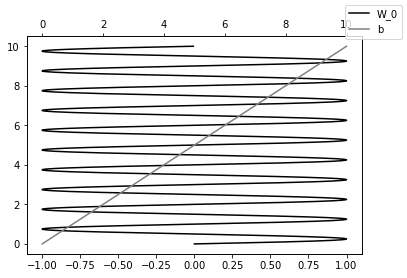

In [2]:
dz = 0.001
L_H = 1
z = np.arange(0, 10, dz)
Nsq_0 = 1

sigma = 1
dt = 1e-4
kz = 2 * np.pi / L_H
w0 = np.sin(kz * z)
kappa = 1e-3
b0 = Nsq_0 *z

fig, ax1 = plt.subplots()
ax2 = ax1.twiny()
ax1.plot(w0, z, label='W_0', c='k')
ax2.plot(b0, z, label='b', c='grey')
fig.legend()

In [3]:
@njit()
def forcing(t, b):
    b_plus = np.roll(b, shift=-1)
    b_minus = np.roll(b, shift=1)

    db_dz = (b_plus - b_minus) / (2 * dz)
    db_dz[-1] = db_dz[-2]
    db_dz[0] = db_dz[1]
    
    d2b_dz2 = (b_plus - 2 * b + b_minus) / dz / dz
    d2b_dz2[-1] = 0
    d2b_dz2[0] = 0

    w = w0 * np.exp(sigma * t)
    
    f = kappa * d2b_dz2 - w * db_dz
    return f

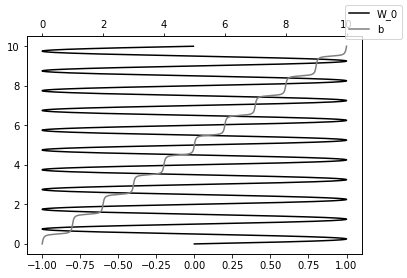

In [4]:
t0 = 0
b1 = b0 + dt * forcing(t0, b0)
t1 = t0 + dt

b2 = b1 + dt * (3 / 2 * forcing(t1, b1) + 1 / 2 * forcing(t0, b0))
t2 = t1 + dt

@njit()
def ab3_iterate(bn0, bn1, bn2, tn3):
    tn2 = tn3 - dt
    tn1 = tn2 - dt
    tn0 = tn2 - dt
    bn3 = bn2 + dt * (23 / 12 * forcing(tn2, bn2) - 16 / 12 * forcing(tn1, bn1) + 5 / 12 * forcing(tn0, bn0))
    return bn3


bn0, bn1, bn2 = b0, b1, b2
tn3 = t2 + dt

for i in range(3000):
    bn3 = ab3_iterate(bn0, bn1, bn2, tn3)
    bn0, bn1, bn2 = bn1, bn2, bn3
    tn3 += dt
    
fig, ax1 = plt.subplots()
ax2 = ax1.twiny()
ax1.plot(w0, z, label='W_0', c='k')
ax2.plot(bn3, z, label='b', c='grey')
fig.legend()

## Two dimensional model

In [2]:
dz = 0.01
dx = 0.01
L_H = 1
L_x = 2

z = np.arange(0, 10, dz)
x = np.arange(0, 1, dx)

x, z = np.meshgrid(x, z)

Nsq_0 = 1
Msq_0 = 0
kappa = 1e-3
sigma = 1
dt = 0.001

kz = 2 * np.pi / L_H
kx = 2 * np.pi / L_x

psi = np.sin(kz * z) * np.sin(kx * x)
w0 = kx * np.sin(kz * z) * np.cos(kx * x)
u0 = - kz * np.sin(kx * x) * np.cos(kz * z)

b0 = Nsq_0 * z + Msq_0 * x

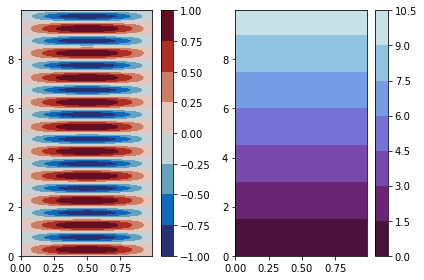

In [3]:
fig, axs = plt.subplots(1, 2)
cax0 = axs[0].contourf(x, z, psi, cmap=cmo.balance)
fig.colorbar(cax0, ax=axs[0])

cax1 = axs[1].contourf(x, z, b0, cmap=cmo.dense_r)
fig.colorbar(cax1, ax=axs[1])

fig.tight_layout()

In [4]:
@njit()
def forcing_2d(t, b):
    # db_dz
    b_plus = b.copy()
    b_plus[:-1] = b[1:]
    #np.roll(b, shift=-1, axis=0)
    b_minus = b.copy()
    b_minus[1:] = b[:-1]
    #np.roll(b, shift=1, axis=0)

    db_dz = (b_plus - b_minus) / (2 * dz)
    db_dz[-1, :] = db_dz[-2, :]
    db_dz[0, :] = db_dz[1, :]
    
    # d2b_dz2
    d2b_dz2 = (b_plus - 2 * b + b_minus) / dz / dz
    d2b_dz2[-1, :] = 0
    d2b_dz2[0, :] = 0    
    
    # db_dx
    b_plus = b.copy()
    b_plus[:, :-1] = b[:, 1:]
    #np.roll(b, shift=-1, axis=1)
    b_minus = b.copy()
    b_minus[:, 1:] = b[:, :-1]
    #np.roll(b, shift=1, axis=1)
    db_dx = (b_plus - b_minus) / (2 * dx)
    db_dx[:, -1] = db_dx[:, -2]
    db_dx[:, 0] = db_dx[:, 1]    

    w = w0 * np.exp(sigma * t)
    u = u0 * np.exp(sigma * t)
    
    f = kappa * d2b_dz2 - w * db_dz - u * db_dx
    return f


KeyboardInterrupt



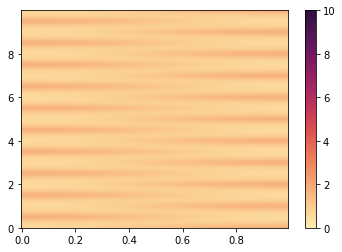

In [5]:
t0 = 0
b1 = b0 + dt * forcing_2d(t0, b0)
t1 = t0 + dt

b2 = b1 + dt * (3 / 2 * forcing_2d(t1, b1) + 1 / 2 * forcing_2d(t0, b0))
t2 = t1 + dt

@njit()
def ab3_iterate_2d(bn0, bn1, bn2, tn3):
    tn2 = tn3 - dt
    tn1 = tn2 - dt
    tn0 = tn2 - dt
    bn3 = bn2 + dt * (23 / 12 * forcing_2d(tn2, bn2) - 16 / 12 * forcing_2d(tn1, bn1) + 5 / 12 * forcing_2d(tn0, bn0))
    return bn3


bn0, bn1, bn2 = b0, b1, b2
tn3 = t2 + dt
bn3 = bn2

b_plus = np.roll(bn3, shift=-1, axis=0)
b_minus = np.roll(bn3, shift=1, axis=0)
db_dz = (b_plus - b_minus) / (2 * dz)
db_dz[-1, :] = db_dz[-2, :]
db_dz[0, :] = db_dz[1, :]
fig, ax1 = plt.subplots()
cax = ax1.pcolormesh(x, z, db_dz, cmap=cmo.matter, shading='nearest', vmin=0, vmax=10)
fig.colorbar(cax, ax=ax1)

for i in range(0, 301):
    bn3 = ab3_iterate_2d(bn0, bn1, bn2, tn3)
    bn0, bn1, bn2 = bn1, bn2, bn3
    tn3 += dt
    
    b_plus = np.roll(bn3, shift=-1, axis=0)
    b_minus = np.roll(bn3, shift=1, axis=0)
    db_dz = (b_plus - b_minus) / (2 * dz)
    db_dz[-1, :] = db_dz[-2, :]
    db_dz[0, :] = db_dz[1, :]
    
    cax = ax1.pcolormesh(x, z, db_dz, cmap=cmo.matter, shading='nearest', vmin=0, vmax=10)
    fig.savefig('./frame/frame{:03d}.png'.format(i))
    


In [6]:
%%bash

ffmpeg -y -framerate 20 -i './frame/frame%03d.png'  -c:v libx264 -pix_fmt yuv420p out.mp4

ffmpeg version 4.3.1 Copyright (c) 2000-2020 the FFmpeg developers
  built with Apple clang version 11.0.3 (clang-1103.0.32.62)
  configuration: --prefix=/opt/local --enable-swscale --enable-avfilter --enable-avresample --enable-libmp3lame --enable-libvorbis --enable-libopus --enable-librsvg --enable-libtheora --enable-libopenjpeg --enable-libmodplug --enable-libvpx --enable-libsoxr --enable-libspeex --enable-libass --enable-libbluray --enable-lzma --enable-gnutls --enable-fontconfig --enable-libfreetype --enable-libfribidi --disable-libjack --disable-libopencore-amrnb --disable-libopencore-amrwb --disable-libxcb --disable-libxcb-shm --disable-libxcb-xfixes --disable-indev=jack --enable-opencl --disable-outdev=xv --enable-audiotoolbox --enable-videotoolbox --enable-sdl2 --disable-securetransport --mandir=/opt/local/share/man --enable-shared --enable-pthreads --cc=/usr/bin/clang --enable-libdav1d --arch=x86_64 --enable-x86asm --enable-libx265 --enable-gpl --enable-postproc --enable-libx

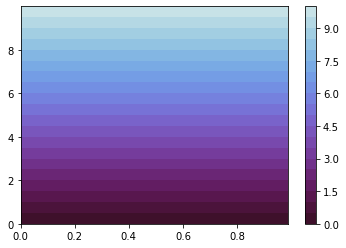

In [9]:
fig, ax = plt.subplots()
cax = ax.contourf(x, z, bn3, cmap=cmo.dense_r, vmin=0, vmax=10.5, levels=20)
fig.colorbar(cax, ax=ax)

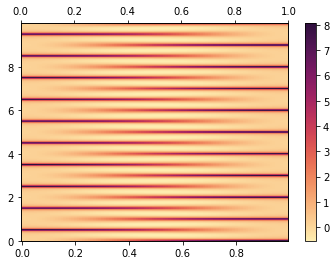

In [10]:
b_plus = np.roll(bn3, shift=-1, axis=0)
b_minus = np.roll(bn3, shift=1, axis=0)
db_dz = (b_plus - b_minus) / (2 * dz)
db_dz[-1, :] = db_dz[-2, :]
db_dz[0, :] = db_dz[1, :]
    

fig, ax1 = plt.subplots()
ax2 = ax1.twiny()
cax = ax1.pcolormesh(x, z, db_dz, cmap=cmo.matter, shading='nearest')
fig.colorbar(cax, ax=ax1)

#ax2.plot(psi[:, 10], z[:, 10])

## The dimensional problem

In [74]:
dz = 2.5
dx = 1e3

z_1d = np.arange(-600, 0, dz)
x_1d = np.arange(0, 150e3, dx)

x, z = np.meshgrid(x_1d, z_1d)

Nsq_0 = 1e-6
Msq_0 = 0
kappa = 1e-6
sigma = 1e-12
dt = 240

kz = 2 * np.pi / 200
kx = 2 * np.pi / 300e3

psi = np.sin(kz * z) * np.sin(kx * x) / np.pi * 5
w0 = kx * np.sin(kz * z) * np.cos(kx * x) / np.pi * 5
u0 = - kz * np.sin(kx * x) * np.cos(kz * z) / np.pi * 5

b0 = Nsq_0 * z + Msq_0 * x

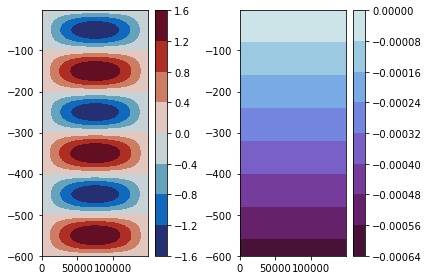

In [56]:
fig, axs = plt.subplots(1, 2)
cax0 = axs[0].contourf(x, z, psi, cmap=cmo.balance)
fig.colorbar(cax0, ax=axs[0])

cax1 = axs[1].contourf(x, z, b0, cmap=cmo.dense_r)
fig.colorbar(cax1, ax=axs[1])

fig.tight_layout()

In [57]:
@njit()
def forcing_2d(t, b):
    # db_dz
    b_plus = b.copy()
    b_plus[:-1] = b[1:]
    #np.roll(b, shift=-1, axis=0)
    b_minus = b.copy()
    b_minus[1:] = b[:-1]
    #np.roll(b, shift=1, axis=0)

    db_dz = (b_plus - b_minus) / (2 * dz)
    db_dz[-1, :] = db_dz[-2, :]
    db_dz[0, :] = db_dz[1, :]
    
    # d2b_dz2
    d2b_dz2 = (b_plus - 2 * b + b_minus) / dz / dz
    d2b_dz2[-1, :] = 0
    d2b_dz2[0, :] = 0    
    
    # db_dx
    b_plus = b.copy()
    b_plus[:, :-1] = b[:, 1:]
    #np.roll(b, shift=-1, axis=1)
    b_minus = b.copy()
    b_minus[:, 1:] = b[:, :-1]
    #np.roll(b, shift=1, axis=1)
    db_dx = (b_plus - b_minus) / (2 * dx)
    db_dx[:, -1] = db_dx[:, -2]
    db_dx[:, 0] = db_dx[:, 1]    

    w = w0 #* np.exp(sigma * t)
    u = u0 #* np.exp(sigma * t)
    
    f = kappa * d2b_dz2 - w * db_dz - u * db_dx
    return f

def db_dz_to_data_array(db_dz):
    da = xr.DataArray(db_dz[..., np.newaxis],
                      coords={'Z': z_1d, 'X': x_1d, 'time': [tn3]})
    return da

In [109]:
t0 = 0

tn3 = 0

if (processed_path / 'toy_strat_data').exists():
    shutil.rmtree(processed_path / 'toy_strat_data')
                  
da = db_dz_to_data_array(db_dz)
da.to_dataset(name='db_dz').to_zarr(processed_path / 'toy_strat_data')

b1 = b0 + dt * forcing_2d(t0, b0)
t1 = t0 + dt

b2 = b1 + dt * (3 / 2 * forcing_2d(t1, b1) + 1 / 2 * forcing_2d(t0, b0))
t2 = t1 + dt

@njit()
def ab3_iterate_2d(bn0, bn1, bn2, tn3):
    tn2 = tn3 - dt
    tn1 = tn2 - dt
    tn0 = tn2 - dt
    bn3 = bn2 + dt * (23 / 12 * forcing_2d(tn2, bn2) - 16 / 12 * forcing_2d(tn1, bn1) + 5 / 12 * forcing_2d(tn0, bn0))
    return bn3


bn0, bn1, bn2 = b0, b1, b2
tn3 = t2 + dt
bn3 = bn2

b_plus = np.roll(bn3, shift=-1, axis=0)
b_minus = np.roll(bn3, shift=1, axis=0)
db_dz = (b_plus - b_minus) / (2 * dz)
db_dz[-1, :] = db_dz[-2, :]
db_dz[0, :] = db_dz[1, :]

for i in range(2, 10000 + 1):
    bn3 = ab3_iterate_2d(bn0, bn1, bn2, tn3)
    bn0, bn1, bn2 = bn1, bn2, bn3
    tn3 += dt
    
    b_plus = np.roll(bn3, shift=-1, axis=0)
    b_minus = np.roll(bn3, shift=1, axis=0)
    db_dz = (b_plus - b_minus) / (2 * dz)
    db_dz[-1, :] = db_dz[-2, :]
    db_dz[0, :] = db_dz[1, :]


    if i % 100 == 0:
        da = db_dz_to_data_array(db_dz)
        da.to_dataset(name='db_dz').to_zarr(processed_path / 'toy_strat_data', append_dim='time')


In [114]:
da = xr.open_dataset(processed_path / 'toy_strat_data', engine='zarr')['db_dz']

In [116]:
da

<xarray.DataArray 'db_dz' (Z: 240, X: 150, time: 101)>
[3636000 values with dtype=float64]
Coordinates:
  * X        (X) float64 0.0 1e+03 2e+03 3e+03 ... 1.47e+05 1.48e+05 1.49e+05
  * Z        (Z) float64 -600.0 -597.5 -595.0 -592.5 ... -10.0 -7.5 -5.0 -2.5
  * time     (time) int64 0 24480 48480 72480 ... 2352480 2376480 2400480

In [299]:
dpi = 300

@dask.delayed
def plot_strat(i):
    
    SMALL_SIZE = 25
    MEDIUM_SIZE = 25
    BIGGER_SIZE = 25
    rc('font',**{'family':'sans-serif','sans-serif':['Arial']})
    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
    
    fig, ax1 = plt.subplots(figsize=(6, 7))

    cax = ax1.pcolormesh(da['X'] * 1e-3, -da['Z'], da.isel(time=i),
                         cmap=cmo.matter,
                         shading='nearest',
                         vmin=0,
                         vmax=5e-6)
    cb = fig.colorbar(cax, ax=ax1, orientation='horizontal', label='$ \partial_z$b (s $^{-2})$')
    cb.formatter.set_useMathText(True)
   
    ax1.contour(da['X'] * 1e-3, -da['Z'], psi, cmap=cmo.balance)
    
    ax1.invert_yaxis()
    ax1.set_xlabel('Longitude (km)')
    ax1.set_ylabel('Depth (m)')
    ax1.set_title('time = {:.2f} days'.format(da['time'].isel(time=i).values / 24 / 60 / 60))

    fig.tight_layout()
    fig.savefig(base_path / 'figures/toy_model_frames/frame{:03d}.png'.format(i), dpi=dpi)
    plt.close(fig)

In [300]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster(processes=False)  # Launches a scheduler and workers locally
client = Client(cluster)  # Connect to distributed cluster and override default.

/Users/goldsworth/miniconda3/envs/dwbc-proj/lib/python3.10/site-packages/distributed/node.py:177: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 57680 instead
  warnings.warn(


In [301]:
collection = [plot_strat(i) for i in range(ds.sizes['time'])]

In [302]:
for elem in collection: elem.compute()

In [303]:
%%bash

ffmpeg -y -framerate 20 -i '../../figures/toy_model_frames/frame%03d.png'  -c:v libx264 -pix_fmt yuv420p ../../figures/toy_model_strat.mp4

ffmpeg version 4.3.1 Copyright (c) 2000-2020 the FFmpeg developers
  built with Apple clang version 11.0.3 (clang-1103.0.32.62)
  configuration: --prefix=/opt/local --enable-swscale --enable-avfilter --enable-avresample --enable-libmp3lame --enable-libvorbis --enable-libopus --enable-librsvg --enable-libtheora --enable-libopenjpeg --enable-libmodplug --enable-libvpx --enable-libsoxr --enable-libspeex --enable-libass --enable-libbluray --enable-lzma --enable-gnutls --enable-fontconfig --enable-libfreetype --enable-libfribidi --disable-libjack --disable-libopencore-amrnb --disable-libopencore-amrwb --disable-libxcb --disable-libxcb-shm --disable-libxcb-xfixes --disable-indev=jack --enable-opencl --disable-outdev=xv --enable-audiotoolbox --enable-videotoolbox --enable-sdl2 --disable-securetransport --mandir=/opt/local/share/man --enable-shared --enable-pthreads --cc=/usr/bin/clang --enable-libdav1d --arch=x86_64 --enable-x86asm --enable-libx265 --enable-gpl --enable-postproc --enable-libx

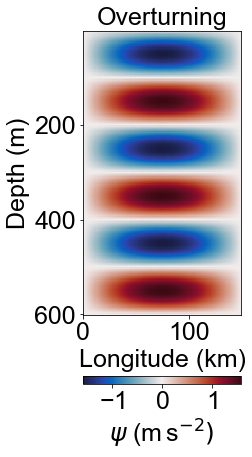

In [291]:
SMALL_SIZE = 25
MEDIUM_SIZE = 25
BIGGER_SIZE = 25
rc('font',**{'family':'sans-serif','sans-serif':['Arial']})
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

fig, ax1 = plt.subplots(figsize=(4, 7))

cax = ax1.pcolormesh(da['X'] * 1e-3, -da['Z'], psi,
                     cmap=cmo.balance,
                     shading='nearest',)
cb = fig.colorbar(cax, ax=ax1, orientation='horizontal', label='$ \psi$ (m$\,$s$^{-2})$')
cb.formatter.set_useMathText(True)

ax1.invert_yaxis()
ax1.set_xlabel('Longitude (km)')
ax1.set_ylabel('Depth (m)')
ax1.set_title('Overturning')

fig.tight_layout()
#fig.savefig(base_path / 'figures/toy_model_frames/frame{:03d}.png'.format(i), dpi=dpi)

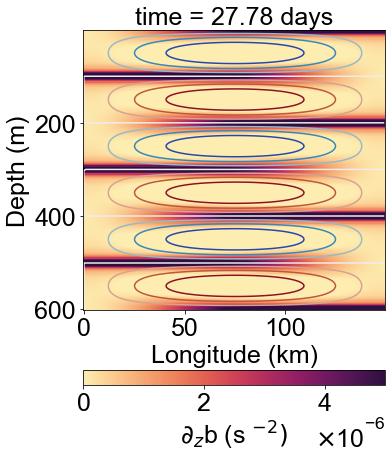

In [297]:

dpi = 300

def plot_strat(i):
    
    SMALL_SIZE = 25
    MEDIUM_SIZE = 25
    BIGGER_SIZE = 25
    rc('font',**{'family':'sans-serif','sans-serif':['Arial']})
    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
    
    fig, ax1 = plt.subplots(figsize=(6, 7))

    cax = ax1.pcolormesh(da['X'] * 1e-3, -da['Z'], da.isel(time=i),
                         cmap=cmo.matter,
                         shading='nearest',
                         vmin=0,
                         vmax=5e-6)
    cb = fig.colorbar(cax, ax=ax1, orientation='horizontal', label='$ \partial_z$b (s $^{-2})$')
    cb.formatter.set_useMathText(True)
    
    ax1.invert_yaxis()
    ax1.set_xlabel('Longitude (km)')
    ax1.set_ylabel('Depth (m)')
    ax1.set_title('time = {:.2f} days'.format(da['time'].isel(time=i).values / 24 / 60 / 60))


    
    fig.tight_layout()
    fig.savefig(base_path / 'figures/toy_model_frames/frame{:03d}.png'.format(i), dpi=dpi)
    
plot_strat(-1)